# Score Table

This notebook estimates the diffusion t-mean for synthetic data compared to the estimation using bridge sampling. Further time-complexity is estimated in this note book

In [1]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics import Frechet_mean
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

import os

import pickle

from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from models import models

2024-03-26 10:48:13.694426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

# Load Estimation Error and Time

In [3]:
manifold = 'Sphere'

In [4]:
path = f"../results/estimates/{manifold}.pkl"
figure_path = "../figures/timing/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [5]:
with open(path, 'rb') as f:
    estimates = pickle.load(f)

## Score Table

### Plotting Estimates

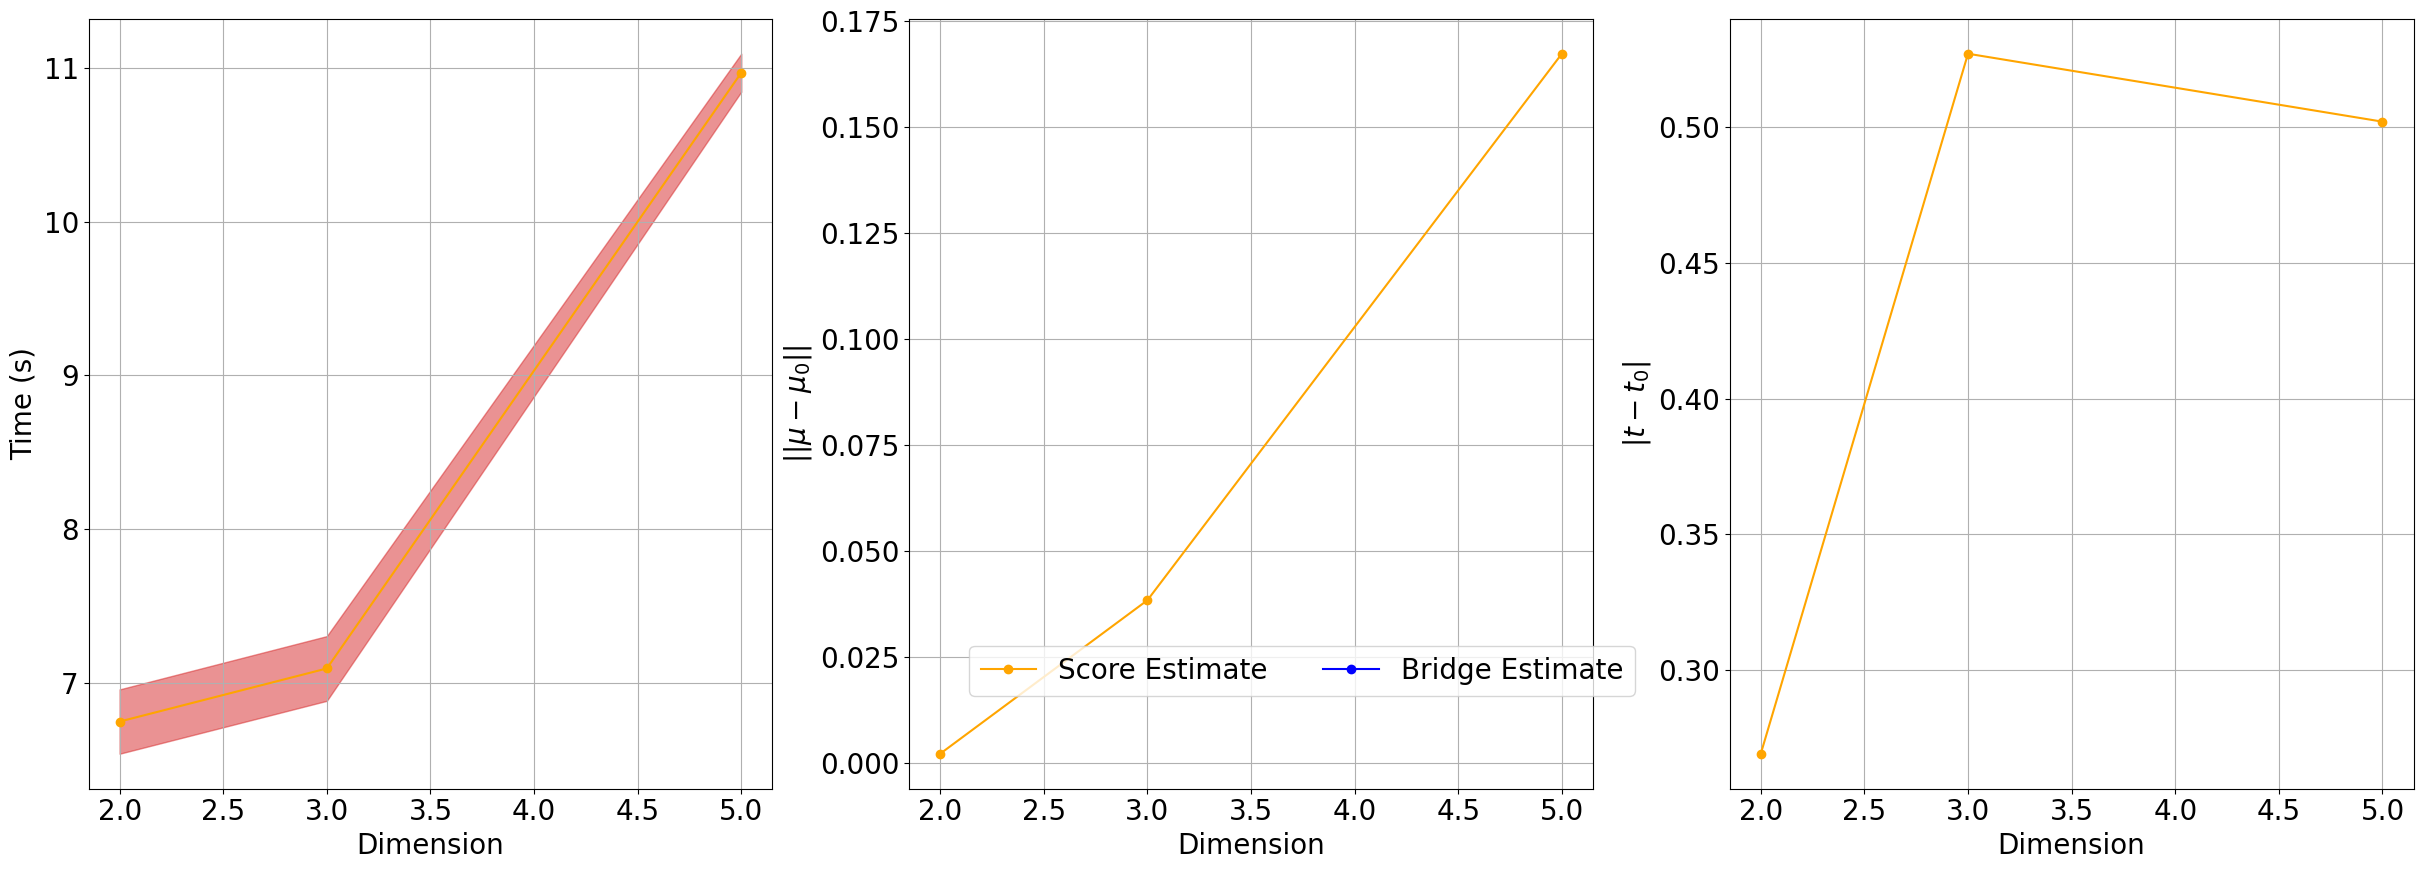

In [20]:
#Plotting time difference
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(131)
ax.plot(estimates['dim'], 
        estimates['score_mu_time'], '-o',color='orange', label='Score Estimate')
ax.plot(estimates['dim'], 
        estimates['bridge_mu_time'], '-o',color='blue', label='Bridge Estimate')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['score_mu_time'] - 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    jnp.maximum(estimates['score_mu_time'] + 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['bridge_mu_time'] - 1.96 * estimates['bridge_std_time'], 
                jnp.zeros_like(estimates['bridge_mu_time'])),
    jnp.maximum(estimates['bridge_mu_time'] + 1.96 * estimates['bridge_std_time'], 
                jnp.zeros_like(estimates['bridge_mu_time'])),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(estimates['dim'], 
        estimates['score_mu_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['bridge_mu_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$||\mu-\mu_{0}||$')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(estimates['dim'], 
        estimates['score_t_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['bridge_t_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$|t-t_{0}|$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.2), ncol=5)

plt.show()

save_path = f'{figure_path}{manifold}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


### Table Estimates

In [21]:
names = [r"muscore", r"mubridge", 
        r"tscore", r"tbridge",
        r"dim", r"s1n", r"s2n", r'score_time', r'bridge_time']

table_dict = estimates.copy()
val = [f"{table_dict['score_mu_time'][i]:.4f} +/- {table_dict['score_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['score_time'] = val
val = [f"{table_dict['bridge_mu_time'][i]:.4f} +/- {table_dict['bridge_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['bridge_time'] = val
table_dict['s1_ntrain'] *= 10
table_dict['s2_ntrain'] *= 10
del table_dict['score_mu_time']
del table_dict['score_std_time']
del table_dict['bridge_mu_time']
del table_dict['bridge_std_time']

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  muscore    mubridge    tscore    tbridge    dim        s1n        s2n  score_time          bridge_time
---------  ----------  --------  ---------  -----  ---------  ---------  ------------------  -------------
   0.0021         nan    0.2693        nan      2  5010.0000  2600.0000  6.7501 +/- 0.1066   nan +/- nan
   0.0383         nan    0.5270        nan      3  5010.0000   760.0000  7.0952 +/- 0.1073   nan +/- nan
   0.1673         nan    0.5020        nan      5  5010.0000   270.0000  10.9673 +/- 0.0630  nan +/- nan


## Frechet Table

In [61]:
manifold = 'Sphere'

In [79]:
path = f"../results/estimates/frechet_{manifold}.pkl"
figure_path = "../figures/timing/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [36]:
with open(path, 'rb') as f:
    estimates = pickle.load(f)

### Plotting Estimates

KeyError: 'frechet_mu_time'

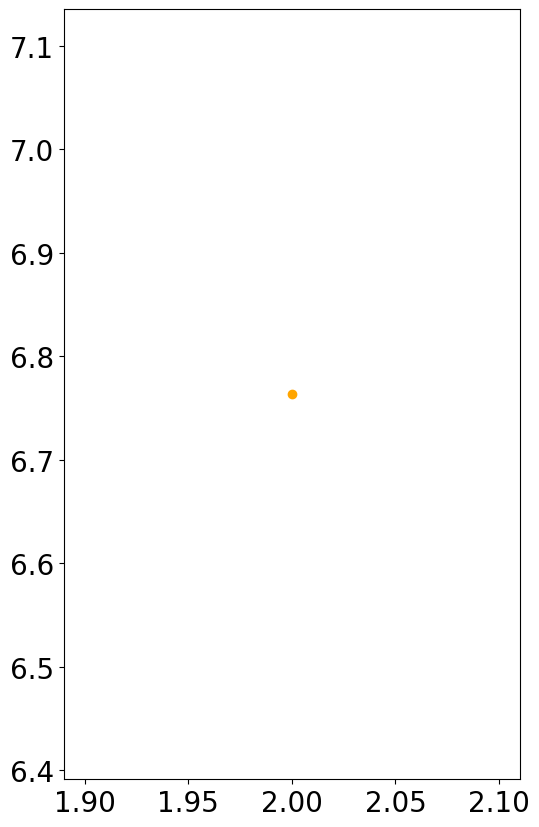

In [62]:
#Plotting time difference
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(131)
ax.plot(estimates['dim'], 
        estimates['score_mu_time'], '-o',color='orange', label='Score Estimate')
ax.plot(estimates['dim'], 
        estimates['frechet_mu_time'], '-o',color='blue', label='Bridge Estimate')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['score_mu_time'] - 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    jnp.maximum(estimates['score_mu_time'] + 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['frechet_mu_time'] - 1.96 * estimates['frechet_std_time'], 
                jnp.zeros_like(estimates['frechet_mu_time'])),
    jnp.maximum(estimates['frechet_mu_time'] + 1.96 * estimates['frechet_std_time'], 
                jnp.zeros_like(estimates['frechet_mu_time'])),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(estimates['dim'], 
        estimates['score_mu_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['frechet_mu_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$||\mu-\mu_{0}||$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.56,0.6), ncol=1)

plt.show()

save_path = f'{figure_path}frechet_{manifold}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


### Table Estimates

In [63]:
names = [r"muscore", r"mufrechet", 
        r"dim", r"s1n", r"s2n", r'score_time', r'frechet_time']

table_dict = estimates.copy()
val = [f"{table_dict['score_mu_time'][i]:.4f} +/- {table_dict['score_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['score_time'] = val
val = [f"{table_dict['frechet_mu_time'][i]:.4f} +/- {table_dict['frechet_mu_time'][i]:.4f}" for i in range(len(table_dict['frechet_mu_time']))]
table_dict['frechet_time'] = val
table_dict['s1_ntrain'] *= 10
table_dict['s2_ntrain'] *= 10
del table_dict['score_mu_time']
del table_dict['score_std_time']
del table_dict['frechet_mu_time']
del table_dict['frechet_std_time']

print(tabulate(table_dict, headers=names, floatfmt=".4f"))

KeyError: 'frechet_mu_time'

### Testing

In [6]:
loss_type = 'dsmdiagvr'
data_path = '../data/'
s2_type = "s2"
dim = 2
manifold= 'Sphere'
generator_dim = 3
if loss_type == "dsmdiagvr":
    s1_path = f"scores/{manifold}{dim}/s1_dsmvr/"
elif loss_type == "dsmdiag":
    s1_path = f"scores/{manifold}{dim}/s1_dsm/"
else:
    s1_path = f"scores/{manifold}{dim}/s1_{loss_type}/"
s2_path = f"scores/{manifold}{dim}/{s2_type}_{loss_type}/"
data_path = f"{data_path}{manifold}{dim}/"
from jaxgeometry.statistics.score_matching.model_loader import load_model

if generator_dim<3:
    layers = [50,100,100,50]
elif generator_dim<5:
    layers = [50,100,200,200,100,50]
elif generator_dim<10:
    layers = [50,100,200,400,400,200,100,50]
elif generator_dim<20:
    layers = [50,100,200,400,800,800,400,200,100,50]
else:
    layers = [50,100,200,400,800,1600,1600,800,400,200,100,50]

s1_ntrain = []
s2_ntrain = []
s1_state = load_model(s1_path)
#s1_ntrain.append(len(jnp.load(''.join((s1_path, 'loss_arrays.npy')))))
if 1:
    s2_state = load_model(s2_path)
    #s2_ntrain.append(len(jnp.load(''.join((s2_path, 'loss_arrays.npy')))))
else:
    s2_state = None
    s2_ntrain.append(jnp.nan)

s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))

if s2_type == "s2":
    s2_model = hk.transform(lambda x: models.MLP_diags2(layers_alpha=layers, layers_beta=layers,
                                                    dim=generator_dim, r = max(generator_dim//2,1))(x))
elif s2_type == "s1s2":
    @hk.transform
    def s2_model(x):

        s1s2 =  models.MLP_s1s2(
            models.MLP_s1(dim=generator_dim, layers=layers), 
            models.MLP_s2(layers_alpha=layers, 
                          layers_beta=layers,
                          dim=generator_dim,
                          r = max(generator_dim//2,1))
            )

        return s1s2(x)[1]

In [7]:
from jaxgeometry.statistics.score_matching import ScoreEvaluation
M = nSphere(N=dim)
#M = SPDN(N=3)
#M = HypParaboloid()
method = 'Embedded'
x0 = M.coords([0.]*dim)
print(x0)
ScoreEval = ScoreEvaluation(M, 
                            s1_model=s1_model,
                            s1_state=s1_state, 
                                    s2_model=s2_model, 
                                    s2_state=s2_state,
                                    s2_approx=1, 
                                    method=method, 
                                    seed=2712)
        
xs = pd.read_csv(''.join((data_path, 'xs.csv')), header=None)
charts = pd.read_csv(''.join((data_path, 'chart.csv')), header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

using M.Exp for Logarithm
(Array([0., 0.], dtype=float32), Array([0., 0., 1.], dtype=float32))


In [8]:
ScoreEval.ggrady_eval(x0,x0,0.5)

Array([[-0.4891876,  0.       ,  0.       ],
       [ 0.       , -4.072646 ,  0.       ],
       [ 0.       ,  0.       ,  2.063027 ]], dtype=float32)

In [9]:
ScoreEval.grady_log(x0,x0,0.5)

Array([-0.00300517,  0.00308011], dtype=float32)

In [10]:
M.gsharp(x0)

Array([[0.25, 0.  ],
       [0.  , 0.25]], dtype=float32)

In [11]:
print(ScoreEval.gradt_log(x0, x0, 0.5))
print(M.gradt_log_hk(x0,x0,0.5))

-2.2803245
-1.8302524


In [12]:
ScoreEval.grady_log((X_obs[0][0],X_obs[1][0]), x0,0.5)

Array([-0.00626353, -0.05401624], dtype=float32)

In [13]:
t_grid = jnp.linspace(0.1,1,100)
val = vmap(lambda t: jnp.mean(vmap(lambda x,c: ScoreEval.gradt_log(x0, (x,c), t))(X_obs[0],X_obs[1])))(t_grid)

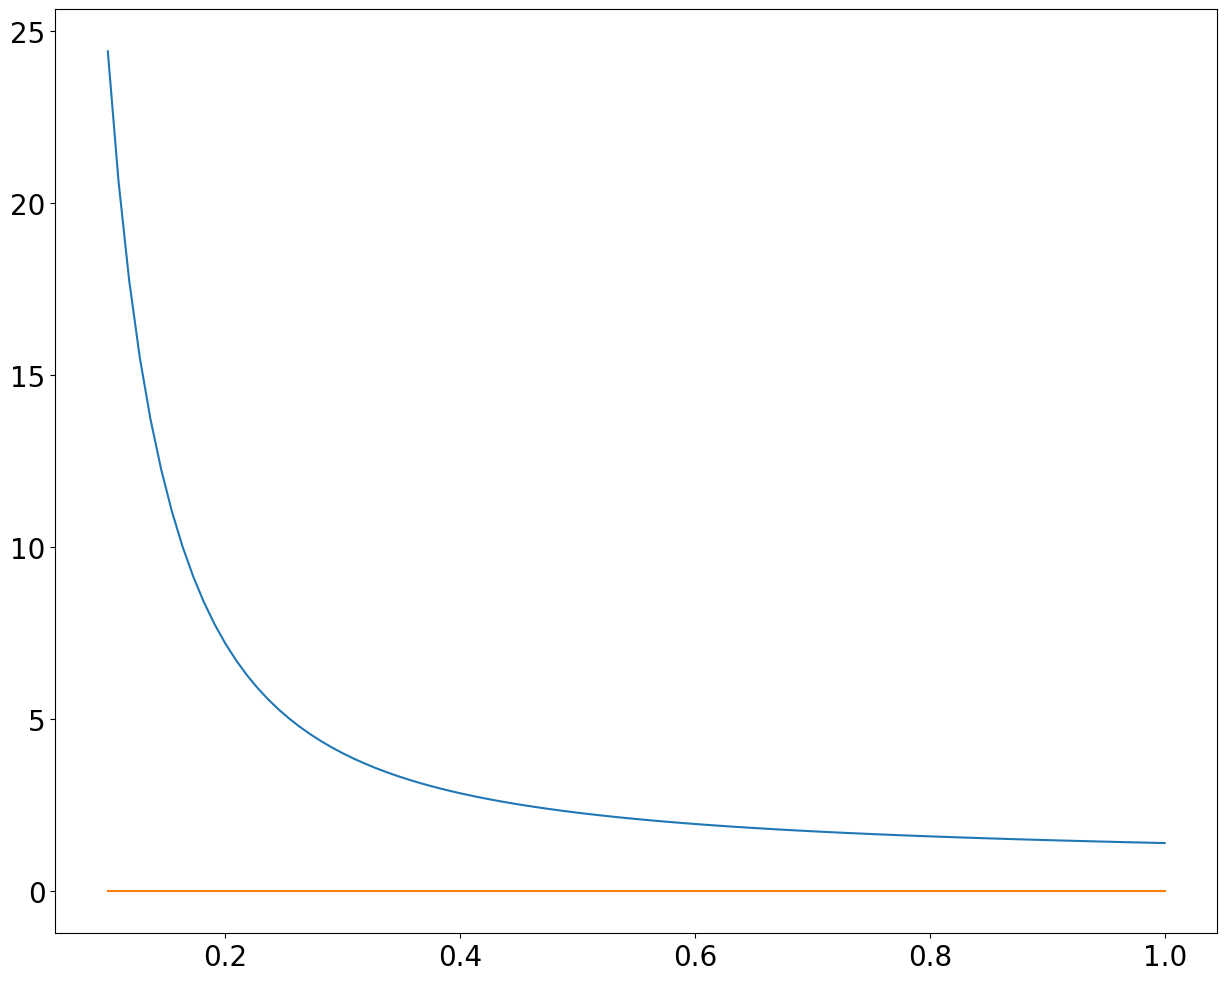

In [14]:
plt.plot(t_grid, val)
plt.plot(t_grid, 0*val)

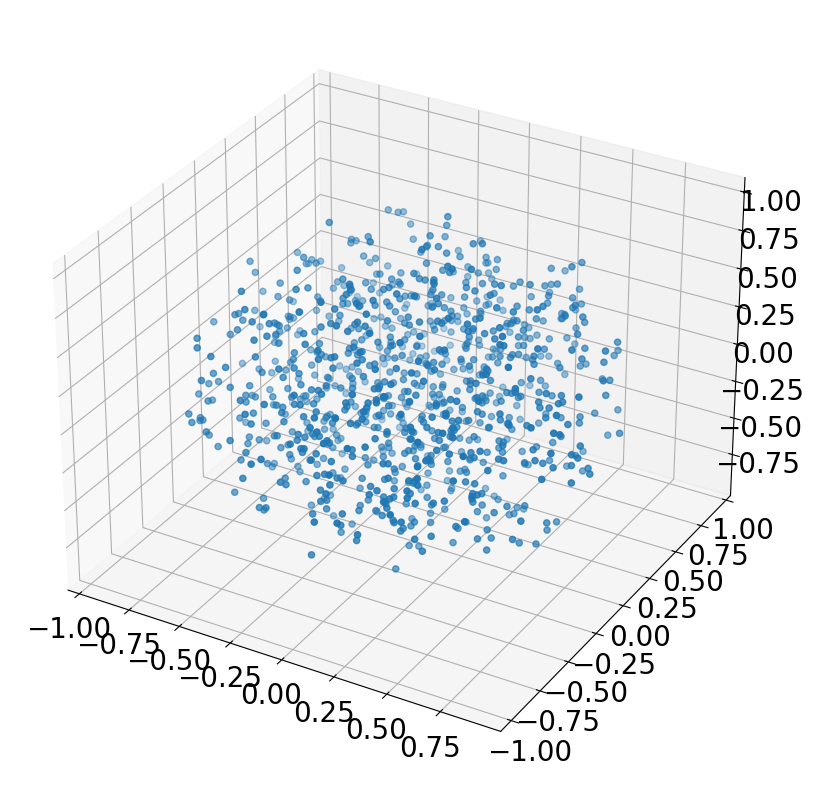

In [106]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_obs[1][:,0], X_obs[1][:,1], X_obs[1][:,2])

In [250]:
X_obs[1][:,0]

Array([ 0.64867157, -0.02818007,  0.57114655, -0.26204833,  0.17182794,
       -0.6061809 , -0.5258969 , -0.69083333, -0.4079143 ,  0.49832124,
       -0.13215357, -0.2675487 ,  0.20738712,  0.47626722, -0.19856815,
        0.5521526 ,  0.02905107, -0.5585689 ,  0.00801593, -0.70084894,
       -0.5403465 ,  0.60743344,  0.35807812, -0.6532643 , -0.64523023,
        0.47714794, -0.01994819,  0.41580573,  0.6132888 , -0.5969904 ,
       -0.6977803 , -0.6064667 , -0.47915685, -0.04654295,  0.8766335 ,
       -0.3496878 ,  0.40325743,  0.0710796 , -0.69612753, -0.07499778,
       -0.17649382,  0.19968252,  0.7735939 ,  0.1985661 ,  0.13138813,
       -0.23115876, -0.6346393 , -0.78865886,  0.19137445,  0.25140226,
        0.65299493, -0.47764042,  0.96520615,  0.80738133,  0.36978415,
        0.6483261 , -0.44831792,  0.42756054, -0.8807968 , -0.11896616,
        0.70972365, -0.7743541 ,  0.9328317 ,  0.09625254, -0.21185705,
        0.2887247 , -0.6727379 ,  0.3675751 ,  0.8021613 ,  0.67

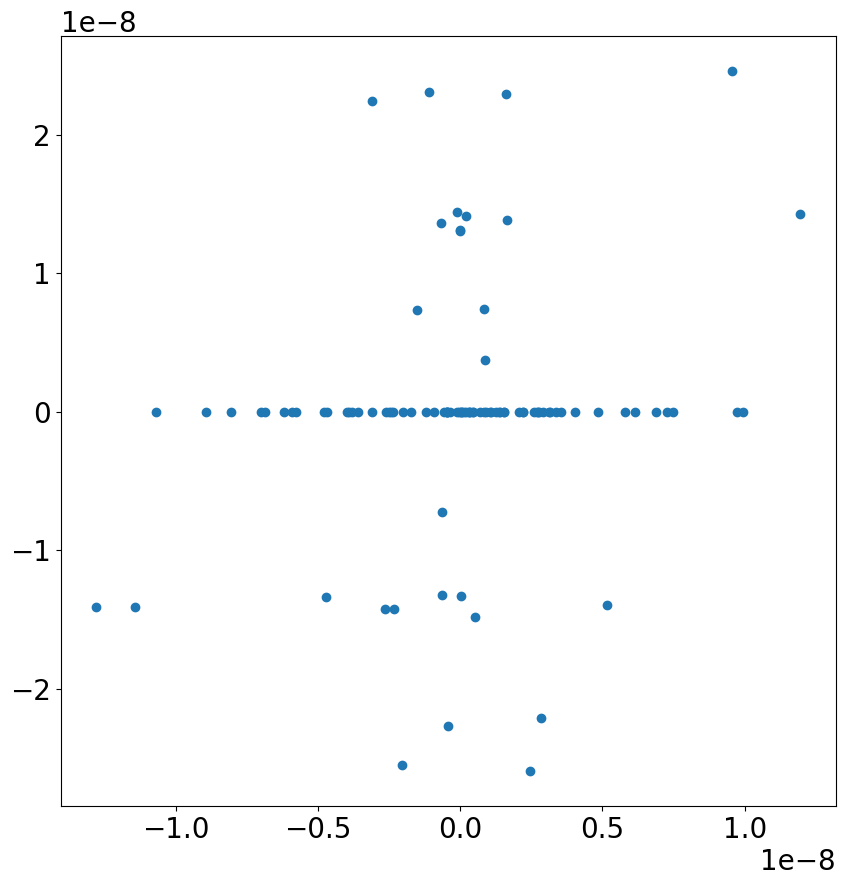

In [251]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1])